This notebook commpares the new augment and scipy cKDtree with the grid search and brute force based search for single query calculations. 

The objective is to check the benefit of augment coordinates against the periodic wrapper of Bio.KDTree in MDAnalysis. 

In [1]:
import numpy as np
from MDAnalysis.lib._augment import augment_coordinates, undo_augment
from gridlocal import FastNS
from MDAnalysis.lib.pkdtree import PeriodicKDTree
from Bio.KDTree import KDTree, _CKDTree
from MDAnalysis.lib.distances import distance_array
from scipy import spatial
import itertools
from tqdm import tqdm_notebook
from collections import defaultdict

In [2]:
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def pkdt_build(box, coords):
    pkdt = PeriodicKDTree(box,bucket_size=10)
    pkdt.set_coords(coords)
    return pkdt
def pkdt_query(struct, coords, query, cutoff):
    struct.search(query,cutoff)
    return np.array(struct.get_indices())

In [4]:
def cbiopython_build(box, coords, cutoff):
    aug, mapping = augment_coordinates(coords, box, cutoff)
    all_coords = np.concatenate([coords, aug])
    kdtree = _CKDTree.KDTree(3, 10)
    kdtree.set_data(all_coords)
    return kdtree, mapping
def cbiopython_query(struct, query, cutoff, mapping, nreal):
    struct.search_center_radius(query,cutoff)
    n = struct.get_count()
    indices = []
    if n:
        indices = np.empty(n, int)
        struct.get_indices(indices)
        indices = undo_augment(np.asarray(indices, dtype=np.int32), mapping, nreal)
        return np.sort(indices)
    else:
        return indices

In [5]:
def biopython_build(box, coords, cutoff):
    aug, mapping = augment_coordinates(coords, box, cutoff)
    all_coords = np.concatenate([coords, aug])
    kdtree = KDTree(dim=3)
    kdtree.set_coords(all_coords)
    return kdtree, mapping
def biopython_query(struct, query, cutoff, mapping, nreal):
    struct.search(query,cutoff)
    indices = np.array(struct.get_indices(), dtype=np.int32)
    indices = undo_augment(indices, mapping, nreal)
    return np.sort(indices)

In [6]:
def scipy_build(box, coords, cutoff):
    aug, mapping = augment_coordinates(coords, box, cutoff)
    all_coords = np.concatenate([coords, aug])
    skdtree = spatial.cKDTree(all_coords)
    return skdtree, mapping
def scipy_query(struct, query, cutoff, mapping, nreal):
    indices = np.asarray(struct.query_ball_point(query,cutoff), dtype=np.int32)
    indices = undo_augment(indices, mapping, nreal)
    return np.sort(indices)

Other helper functions

In [7]:
def get_coords(box,Npoints):
    return (np.random.uniform(low=0,high=1.0,size=(Npoints,3))*box[:3]).astype(np.float32)

  * check for correctness

In [8]:
#Initialize
BOX = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
CUTOFF = 4.
NPOINTS = 100000
points = get_coords(BOX, NPOINTS)

In [9]:
query = np.array([1.,1.,1.], dtype = np.float32)

In [10]:
pkdt = pkdt_build(BOX, points)
indices_pkdt = pkdt_query(pkdt, points, query, CUTOFF)

In [11]:
indices_pkdt 

array([ 6897,  7341,  9388, 10334, 11769, 19379, 27860, 32470, 37240,
       44433, 44482, 44639, 46849, 49177, 52144, 59758, 64472, 67103,
       69312, 69829, 70359, 81703, 83067, 85496, 87325, 87452, 90301,
       91093, 98318])

In [12]:
bp, bmapping = biopython_build(BOX, points, CUTOFF)

In [14]:
indices_bp = biopython_query(bp, query, CUTOFF, bmapping, len(points))

In [15]:
indices_bp

array([ 6897,  7341,  9388, 10334, 11769, 19379, 27860, 32470, 37240,
       44433, 44482, 44639, 46849, 49177, 52144, 59758, 64472, 67103,
       69312, 69829, 70359, 81703, 83067, 85496, 87325, 87452, 90301,
       91093, 98318])

In [16]:
cbp, cmapping = cbiopython_build(BOX, points, CUTOFF)

In [17]:
indices_cbp = cbiopython_query(cbp, query, CUTOFF, cmapping, len(points))

In [18]:
indices_cbp

array([ 6897,  7341,  9388, 10334, 11769, 19379, 27860, 32470, 37240,
       44433, 44482, 44639, 46849, 49177, 52144, 59758, 64472, 67103,
       69312, 69829, 70359, 81703, 83067, 85496, 87325, 87452, 90301,
       91093, 98318])

In [19]:
sc,  smapping = scipy_build(BOX, points, CUTOFF)

In [20]:
indices_scipy= scipy_query(sc, query, CUTOFF, smapping, len(points))

In [21]:
indices_scipy

array([ 6897,  7341,  9388, 10334, 11769, 19379, 27860, 32470, 37240,
       44433, 44482, 44639, 46849, 49177, 52144, 59758, 64472, 67103,
       69312, 69829, 70359, 81703, 83067, 85496, 87325, 87452, 90301,
       91093, 98318])

In [22]:
for (a,b) in itertools.combinations([indices_pkdt, indices_bp, indices_cbp,  indices_scipy],2):
    np.testing.assert_array_equal(a, b)

# Benchmark

In [23]:
#initialize
box = np.array([100.,100.,100.,90.,90.,90.],dtype=np.float32)
cutoff = 10.
npoints = np.logspace(2,5, num = 10, dtype = np.int)
query = np.array([1.,1.,1.], dtype = np.float32) ## Close to the one of the phases

In [26]:
from tqdm import tqdm_notebook

res_build = defaultdict(list)
res_query = defaultdict(list)
res_total = defaultdict(list)

for N in tqdm_notebook(np.unique(npoints)):
    points = get_coords(box, N)
    
    # Build
    pkdt = pkdt_build(box, points)
    bp, bmapping = biopython_build(box, points, cutoff)
    cbp, cmapping = cbiopython_build(box, points, cutoff)
    sc, smapping = scipy_build(box, points, cutoff)
    
    # Run
    qres = %timeit -q -o pkdt_query(pkdt, points, query, cutoff)
    res_query['pkdtree'].append(qres.average)
    
    bres = %timeit -q -o pkdt_build(box, points)
    res_build['pkdtree'].append(bres.average)
    
    res_total['pkdtree'].append(bres.average + qres.average)
    
    # Biopython KDTree + Augment
    qres = %timeit -q -o biopython_query(bp, query, cutoff, bmapping, len(points))
    res_query['augment+KDtree'].append(qres.average)
    
    bres = %timeit -q -o biopython_build(box, points, cutoff)
    res_build['augment+KDtree'].append(bres.average)
    res_total['augment+KDtree'].append(bres.average + qres.average)
    
    
    # Biopython cKDTree + Augment
    qres = %timeit -q -o cbiopython_query(cbp, query, cutoff, cmapping, len(points))
    res_query['augment+cKDtree'].append(qres.average)
    
    bres = %timeit -q -o cbiopython_build(box, points, cutoff)
    res_build['augment+cKDtree'].append(bres.average)
    res_total['augment+cKDtree'].append(bres.average + qres.average)
    
    # Scipy cKDTree + Augment
    qres = %timeit -q -o scipy_query(sc, query, cutoff, smapping, len(points))
    res_query['augment+scipy-KDtree'].append(qres.average)
    
    bres = %timeit -q -o scipy_build(box, points, cutoff)
    res_build['augment+scipy-KDtree'].append(bres.average)
    res_total['augment+scipy-KDtree'].append(bres.average + qres.average)

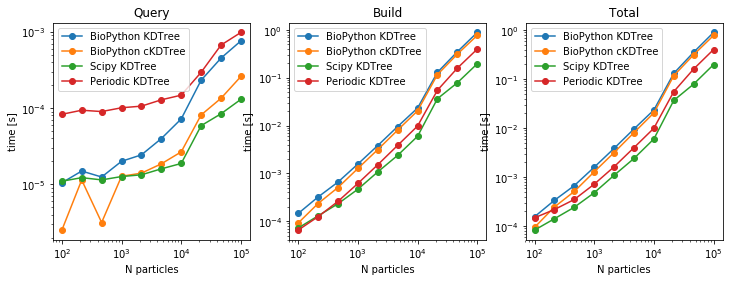

In [27]:
fig, axes = plt.subplots(ncols = 3, figsize = plt.figaspect(1/3))

ax = axes[0]

ax.plot(npoints, res_query['augment+KDtree'], 'o-', label='BioPython KDTree')
ax.plot(npoints, res_query['augment+cKDtree'], 'o-', label='BioPython cKDTree')
ax.plot(npoints, res_query['augment+scipy-KDtree'], 'o-', label='Scipy KDTree')
ax.plot(npoints, res_query['pkdtree'], 'o-', label='Periodic KDTree')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Query')
ax.legend()

ax = axes[1]
ax.plot(npoints, res_build['augment+KDtree'], 'o-', label='BioPython KDTree')
ax.plot(npoints, res_build['augment+cKDtree'], 'o-', label='BioPython cKDTree')
ax.plot(npoints, res_build['augment+scipy-KDtree'], 'o-', label='Scipy KDTree')
ax.plot(npoints, res_build['pkdtree'], 'o-', label='Periodic KDTree')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Build')
ax.legend()

ax = axes[2]
ax.plot(npoints, res_total['augment+KDtree'], 'o-', label='BioPython KDTree')
ax.plot(npoints, res_total['augment+cKDtree'], 'o-', label='BioPython cKDTree')
ax.plot(npoints, res_total['augment+scipy-KDtree'], 'o-', label='Scipy KDTree')
ax.plot(npoints, res_total['pkdtree'], 'o-', label='Periodic KDTree')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Total')
ax.legend()

* The performance of KDtree and cKDTree in biopython are compared with augment coordinates to deal with periodic calculations. It can be observed that the build time of cKDtree is little faster than than of KDtree. However, query time of cKDTree is significantly faster than the KDtree i.e. ~5x per query.
* To compare the performance of augment coordinates (BioPython cKDTree) with the current implementation of Periodic KDTree, the difference in query time is significant. Therefore, augmenting coordinates improves the performance of the _CKDTree as compared to Periodic KDTree. 
* It can also be seen that KDTree implementation of scipy takes less time for build as well as almost similar time to evaluate fixed radius query. Furthermore, scipy.spatial.cKDTree is more stable compared to Biopython._CKDTree (I assume it because of _CKDTree being an internal method). 

Clearly, augment coordinates is advantageous over the current implementation but it requires complete overhaul of all the implementation of kdtree in MDAnalysis. 

Therefore, the recommendation is to replace the Bio.KDTree with scipy.spacial which is a stable KDTree version and use cythonized version to evaluate the distance from the images.